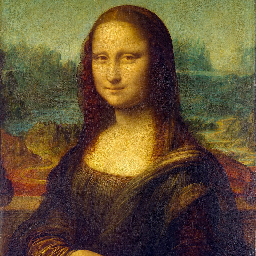

In [1]:
from PIL import Image

width = 256
height = 256

content_source = Image.open("images/content.png").resize((width, height))
content_source

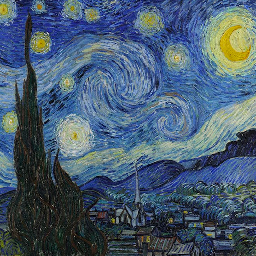

In [2]:
style_source = Image.open("images/style.jpg").resize((width, height))
style_source

In [3]:
import numpy as np

content_source = np.asarray(content_source, dtype='float32')
style_source = np.asarray(style_source, dtype='float32')


In [4]:
from keras import backend as K


Using TensorFlow backend.


# TRANSFER LEARNING

As we saw with our CIFAR example, the more complex the data and architecture gets in our A.I. models, the more it takes in terms of resources and time to train the A.I.

Transfer Learning allows us to use or **repurpose** large sections of previously trained, robust models and build on top of them.

We will be leveraging the VGG16 Architecture and Weights developed by *Visual Geometry Group* of Oxford University to win the ImageNet competition in 2014. We will be using the 16 layer deep version of the model, which comes with keras.

In [5]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [6]:
# SINCE WE ARE USING A PRE-TRAINED MODEL (VGG16), WE NEED TO MAKE OUR IMAGES "VGG" FRIENDLY
# (RGB or BGR, MEAN PIXELS, ETC...) TO DO THIS, WE ARE GOING TO USE A HELPER CLASS I MADE FOR US
import Helpers

helper = Helpers.Style_Transfer(K, width, height)

In [7]:
content_data = helper.to_VGG_format(content_source)
style_data = helper.to_VGG_format(style_source)

Since we won't be creating our model sequentially from from scratch, but leveraging a robust, previously built model, we need to interface with the model a little bit differently. Here, we will create some variables that will tell keras that we have our own 'tensors' we want to keep track of as we load and interact with the VGG model.

In [8]:
content_image = K.variable(content_data)
style_image = K.variable(style_data)
result_image = K.placeholder((1, width, height, 3))

In [9]:
print(content_image.shape)

(1, 256, 256, 3)


In [10]:
# LET'S COMBINE THESE THREE KERAS VARIABLES INTO A GROUP,
# WITH CONTENT FIRST, THEN STYLE, THEN THE PLACEHOLDER FOR OUR RESULTS...
input_tensor = K.concatenate([content_image,
                                    style_image,
                                    result_image], axis=0)

print(input_tensor.shape)

(3, 256, 256, 3)


In [11]:
# LET'S MAKE SURE WE KEEP TRACK OF THEIR ORDERING, AS IT WILL MAKE THE FOLLOWING CODE EASIER
# TO READ AND KNOW WHICH IMAGE WE ARE WORKING WITH...
CONTENT_INDEX = 0
STYLE_INDEX = 1
RESULT_INDEX = 2

In [12]:
# NOW WE'RE READY TO ACTUALLY CREATE AN INSTANCE OF OUR VGG MODEL AND GIVE IT OUR INPUT VARIABLES
# NOTICE THAT WE WANT THIS MODEL WITH 'ALREADY TRAINED' WEIGHTS AND WE DON'T NEED TO FINAL CLASSIFIER LAYERS,
# WE'RE JUSTING USING THE MODEL FOR ITS ABILITY TO "UNDERSTAND" WHAT IT SEES, WE DON'T NEED IT 
# TO DO THE TOP STEP AND ACTUALLY CLASSIFY THE IAGES FOR US...
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [13]:
# LET'S LOOK AT THE LAYERS THAT WE GOT FROM THE MODEL
# YOU'LL NOTICE THAT WE DON'T HAVE THE FINAL (TOP) LAYERS IF YOU COMPARE THIS
# WITH THE FULL VGG MODEL FOUND HERE: 
# http://book.paddlepaddle.org/03.image_classification/image/vgg16.png

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 32, 32, 512) dtype=float32>,
 'block4_co

![Image of VGG Layers](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

In [14]:
loss_chain = K.variable(0.)

In [15]:
content_weight = 0.025

content_data = layers['block2_conv2'][CONTENT_INDEX,...]
result_data  = layers['block2_conv2'][RESULT_INDEX,...]
loss_chain += content_weight * helper.content_loss(content_data, result_data)


In [16]:
style_weight = 1.2

# WHERE AS WE ONLY USED ONE BOTTOM LAYER TO CALCULATE THE CONTENT LOSS, 
# WE NEED TO AVERAGE OUT A FEW UPPER LAYERS TO CALCULATE THE MORE ABSTRACT IDEA OF 'STYLE'
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    style_data = layers[layer_name][STYLE_INDEX,...]
    result_data = layers[layer_name][RESULT_INDEX,...]
    loss_chain += style_weight * helper.style_loss(style_data, result_data)
    

In [17]:
noisy_weight = 0.9

loss_chain += noisy_weight * helper.noisy_loss(result_image)

In [18]:
# NOW THAT WE HAVE THE LOSS_CHAIN, WE ARE READY TO CALCULATE THE GRADIENTS AND TWEAKS

helper.setup_gradients_from_loss_chain(loss_chain, result_image)


In [19]:
# NOW WE'RE ALL READY TO LOOP THROUGH OUR SETUP, RUNNING SOME CALCULUS MAGIC EVERY 
# TURN OF THE CRANK, AND SEE OUR RESULTS SLOWLY GET TWEAKED TO A STYLE TRANSFER RESULT!

from scipy.optimize import fmin_l_bfgs_b as calculus_magic
import time


In [20]:
# WE INITIALLY SEED OUR RESULT IMAGE WITH RANDOM DATA. THE AI NEEDS TO START WITH SOMETHING TO TWEAK!
calculated_result_data = np.random.uniform(0, 255, (1, width, height, 3)) - 128.  

In [21]:
for i in range(4):
    print('Start of iteration', i)
    start_time = time.time()
    calculated_result_data, min_val, _ = calculus_magic(helper.loss, 
                                   calculated_result_data.flatten(), 
                                   fprime=helper.gradients, 
                                   maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 4.04617e+10
Iteration 0 completed in 77s
Start of iteration 1
Current loss value: 1.48311e+10
Iteration 1 completed in 76s
Start of iteration 2
Current loss value: 9.74701e+09
Iteration 2 completed in 76s
Start of iteration 3
Current loss value: 7.84326e+09
Iteration 3 completed in 77s


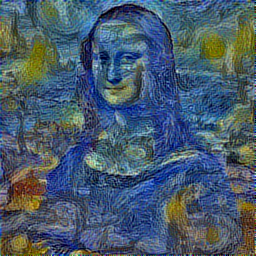

In [22]:
# NOW LET'S SEE WHAT WE GOT. DON'T CONVERT TO CONVERT BACK FROM VGG FORMAT 
snapshot = helper.from_VGG_format(np.copy(calculated_result_data))
Image.fromarray(snapshot)